## Antibody escape

Analysis of the degree of antibody escape

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300
L = 15
sequences_int = range(2**L)

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N',
                  'T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']


In [3]:
import matplotlib.transforms as transforms
from tqdm.notebook import tqdm

df = pd.read_csv("../../Titeseq/results/Kds/cleaned_Kds_RBD_ACE2.tsv",
                 dtype={"geno":"str"}, sep="\t")
df["variant_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'


dft = df.set_index("geno")
dfpl = pd.DataFrame()
kds = dft.log10Kd.to_dict()
errkds = dft.err_log10Kd.to_dict()
nbmuts, deltas, muts, keeps, deltas_err, sources, targets = [], [], [], [], [], [], []
for im, m in tqdm(enumerate(mutation_names)):
    muts += [m]*(len(df))
    for s in df.geno:
        deltas += [kds[s] - kds[s[:im] + '1' + s[im+1:]]]
        deltas_err += [np.sqrt(errkds[s]**2 + errkds[s[:im] + '1' + s[im+1:]]**2)]
        nbmuts += [s.count('1')]
        keeps += [s[im] != '1']
        sources += [s]
        targets += [s[:im] + '1' + s[im+1:]]

dfpl = pd.DataFrame()
dfpl["Mutation"] = muts
dfpl[r'$\Delta \log_{10}(K_d)$'] = deltas
dfpl[r'$\Delta \log_{10}(K_d)$'] = -dfpl[r'$\Delta \log_{10}(K_d)$']
dfpl[r'Number of mutations'] = nbmuts
dfpl[r'err_ΔKd'] = deltas_err
dfpl[r'source'] = sources
dfpl[r'target'] = targets
dfpl = dfpl[keeps]


0it [00:00, ?it/s]

In [6]:
## add mean antibody escape
dfae = pd.read_csv("./../../Additional_data/antibody_escape/escape_data.csv", low_memory=False)
dfae["full_mutation"] = dfae.wildtype + dfae.site.apply(str) + dfae.mutation
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
effect = dfae[dfae.full_mutation.isin(mutation_names)].groupby("full_mutation").site_mean_escape.mean().to_dict()
dfpl["Antibody Escape"] = dfpl.Mutation.map(effect)


In [7]:
dfplot = pd.DataFrame()
mutations, effect_wu, effect_om, ab_esc = [], [], [], []
for m in dfpl.Mutation.unique():
    mutations += [m]
    effect_wu += [dfpl[(dfpl.source == '0'*15) & (dfpl.Mutation == m)][r'$\Delta \log_{10}(K_d)$'].iloc[0]]
    effect_om += [dfpl[(dfpl.source.str.count('1') == L-1) & (dfpl.Mutation == m)][r'$\Delta \log_{10}(K_d)$'].iloc[0]]
    ab_esc += [effect[m]]
dfplot["Mutation"] = mutations
dfplot["Effect_Wuhan"] = effect_wu 
dfplot["Effect_Omicron"] = effect_om
dfplot["Ab_escape"] = ab_esc
dfplot["Effect_Omicron_background-Effect_Wuhan_background"] = -dfplot["Effect_Wuhan"] + dfplot["Effect_Omicron"]




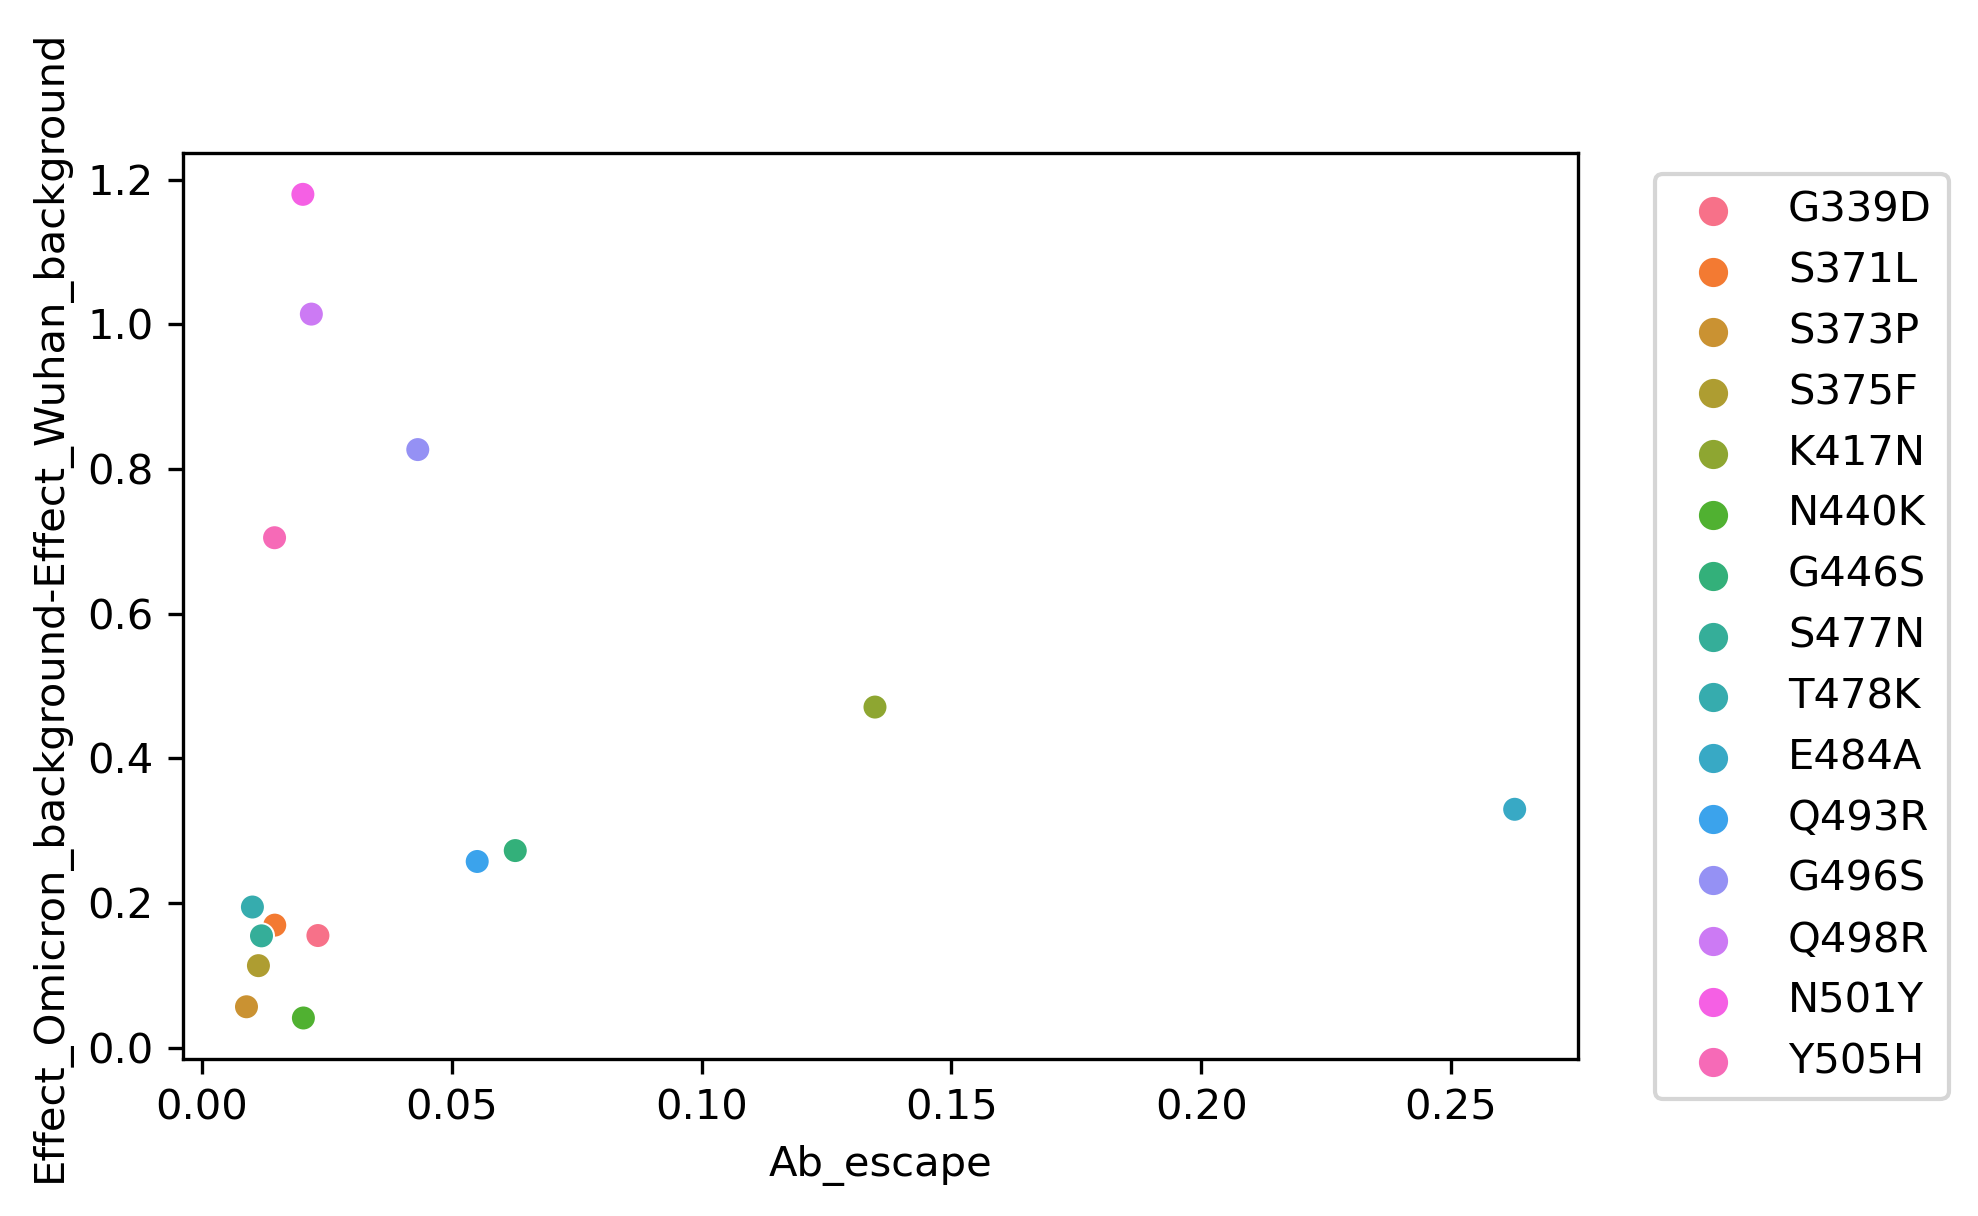

In [9]:
sns.scatterplot(data=dfplot, x="Ab_escape", 
                y="Effect_Omicron_background-Effect_Wuhan_background",
                hue="Mutation")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## save the data to plot the paper figure
dfplot[["Effect_Omicron_background-Effect_Wuhan_background",
        "Ab_escape", "Mutation"]].to_csv("../Figures/data/deltadeltadeltag.csv")